In [1]:
%%capture
!pip install torchinfo

In [2]:
# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split as tts

# Torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.models import vit_b_16, ViT_B_16_Weights

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix

# os
import os

# Path
from pathlib import Path

# random
import random

# tqdm
from tqdm.auto import tqdm

# OrderedDict
from collections import OrderedDict

# warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
def display_images(images,n_cols=4):
    for i in range(0,len(images),n_cols):
        fig, axes = plt.subplots(1, n_cols, figsize=(4*n_cols, 5))
        for j in range(i,i+n_cols):
            if j<len(images):
                axes[j%n_cols].imshow(images[j], cmap='gray')
                axes[j%n_cols].axis('off')  # Hide axes
        plt.show()

In [4]:
# Total Images

IMAGE_PATH = Path("../input/adulterated-red-chilli-powder-dataset/Dataset for Adulterated Red Chilli Powder with Brick Powder")

IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*/*/*/*.jpg"))

print(f'Total Images = {len(IMAGE_PATH_LIST)}')

IMAGE_SIZE = (64, 64)  # Resize images to this size
BATCH_SIZE = 32
# EPOCHS = 50

Total Images = 481


In [5]:
CLASSES = ['Red chilli powder normal Sample', 'Red chilli powder with 5 to 100 % brick powder']
ANOMALY_CLASSES = [
    'Red chilli powder with 5_ brick powder',
    'Red chilli powder with 10_ brick powder',
    'Red chilli powder with 15_ brick powder',
    'Red chilli powder with 20_ brick powder',
    'Red chilli powder with 25_ brick powder',
    'Red chilli powder with 30_ brick powder',
    'Red chilli powder with 35_ brick powder',
    'Red chilli powder with 40_ brick powder',
    'Red chilli powder with 45_ brick powder',
    'Red chilli powder with 50_ brick powder',
    'Brick powder normal sample'
]

# Function to load and preprocess images
def load_images_from_paths(image_paths, image_size):
    images = []
    for img_path in image_paths:
        img = cv2.imread(str(img_path))
        height, width = img.shape[:2]
        new_height = 1024 
        new_width = 1024

        # Calculate the coordinates for the top left corner of the crop
        start_x = (width) // 2 - new_height
        start_y = (height) // 2  - new_height
        if img is not None:
            if start_x>=0 and start_y>=0 and new_height<width and new_width<height:
                img=img[start_y:start_y+new_height, start_x:start_x+new_width]
            img = cv2.resize(img, image_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
    return np.array(images)

# Load images for normal and anomaly classes
print("==" * 30)
print(" " * 15, f"Total Classes = {len(CLASSES)}")
print("==" * 30)

for c in CLASSES:
  if(c=='Red chilli powder normal Sample')  :
    total_images_classe_normal = list(Path(os.path.join(IMAGE_PATH, c)).glob("*/*/*.jpg"))
    print(f'* {c}: {len(total_images_classe_normal)} images')
  else :
    total_images_classe_anomaly=[]
    for j in ANOMALY_CLASSES:
       total_images_classe_anomaly.extend(list(Path(os.path.join(IMAGE_PATH, j)).glob("*/*/*.jpg")))         
    print(f'* Red chilli powder with 5 to 100 % brick powder: {len(total_images_classe_anomaly)} images')

                Total Classes = 2
* Red chilli powder normal Sample: 40 images
* Red chilli powder with 5 to 100 % brick powder: 441 images


In [6]:
# display_images([cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB) for img_path in total_images_classe_normal])
len(total_images_classe_normal)

40

In [7]:
# display_images([cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB) for img_path in total_images_classe_anomaly])
len(total_images_classe_anomaly)

441

In [8]:
# Load data
normal_images = load_images_from_paths(total_images_classe_normal, IMAGE_SIZE)
anomaly_images = load_images_from_paths(total_images_classe_anomaly, IMAGE_SIZE)

In [9]:
# blurred_normal_images =np.array([cv2.GaussianBlur(img, (5, 5), 0 ) for img in normal_images])
# blurred_anomal_images =np.array([cv2.GaussianBlur(img, (5, 5), 0 ) for img in anomaly_images])

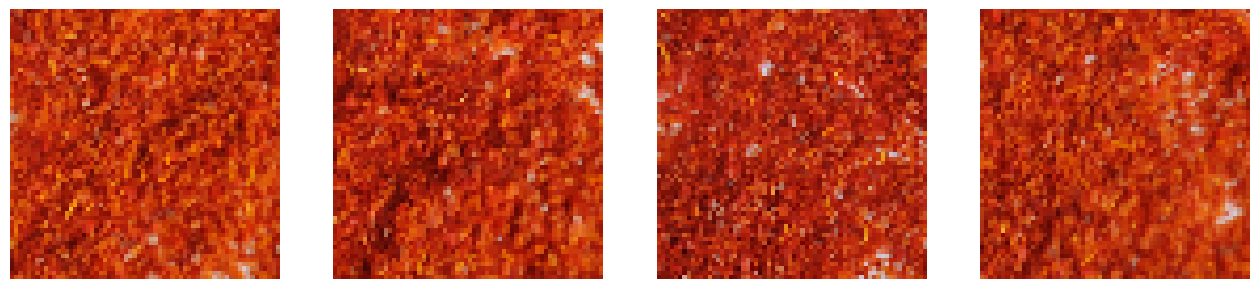

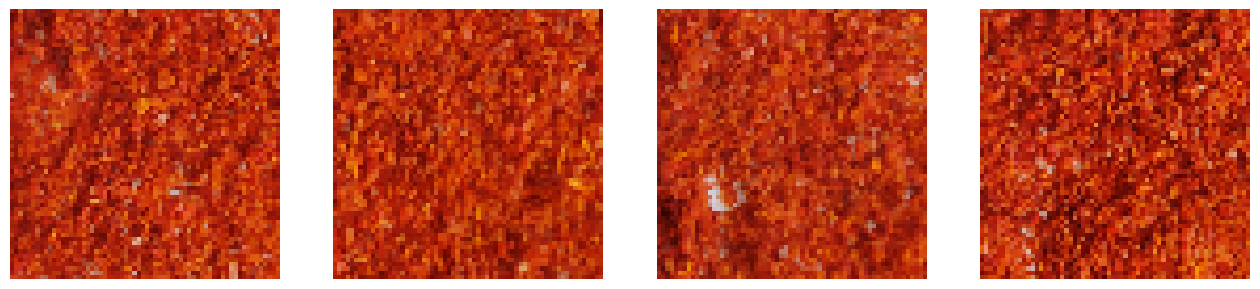

In [10]:
display_images(normal_images[:8])

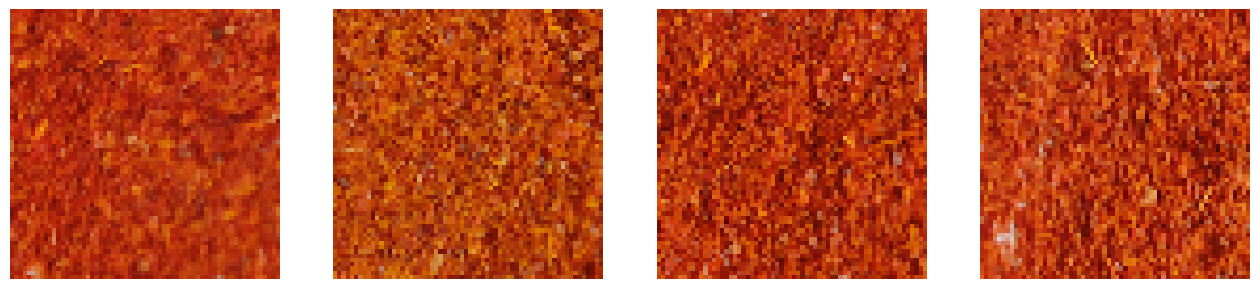

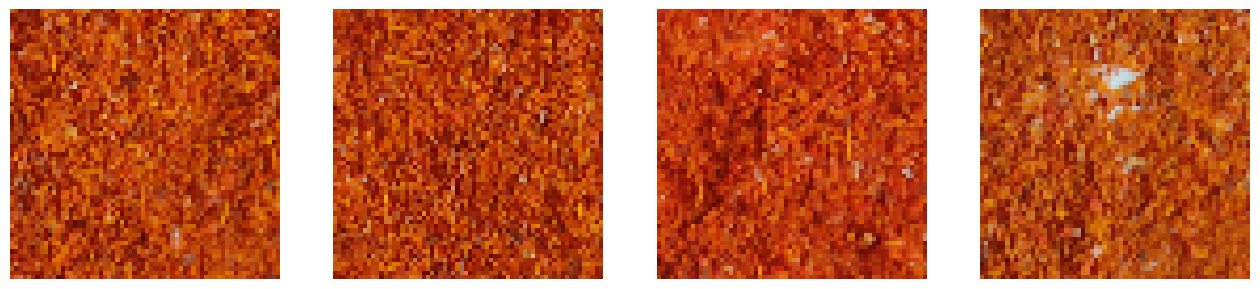

In [11]:
display_images(anomaly_images[:8])

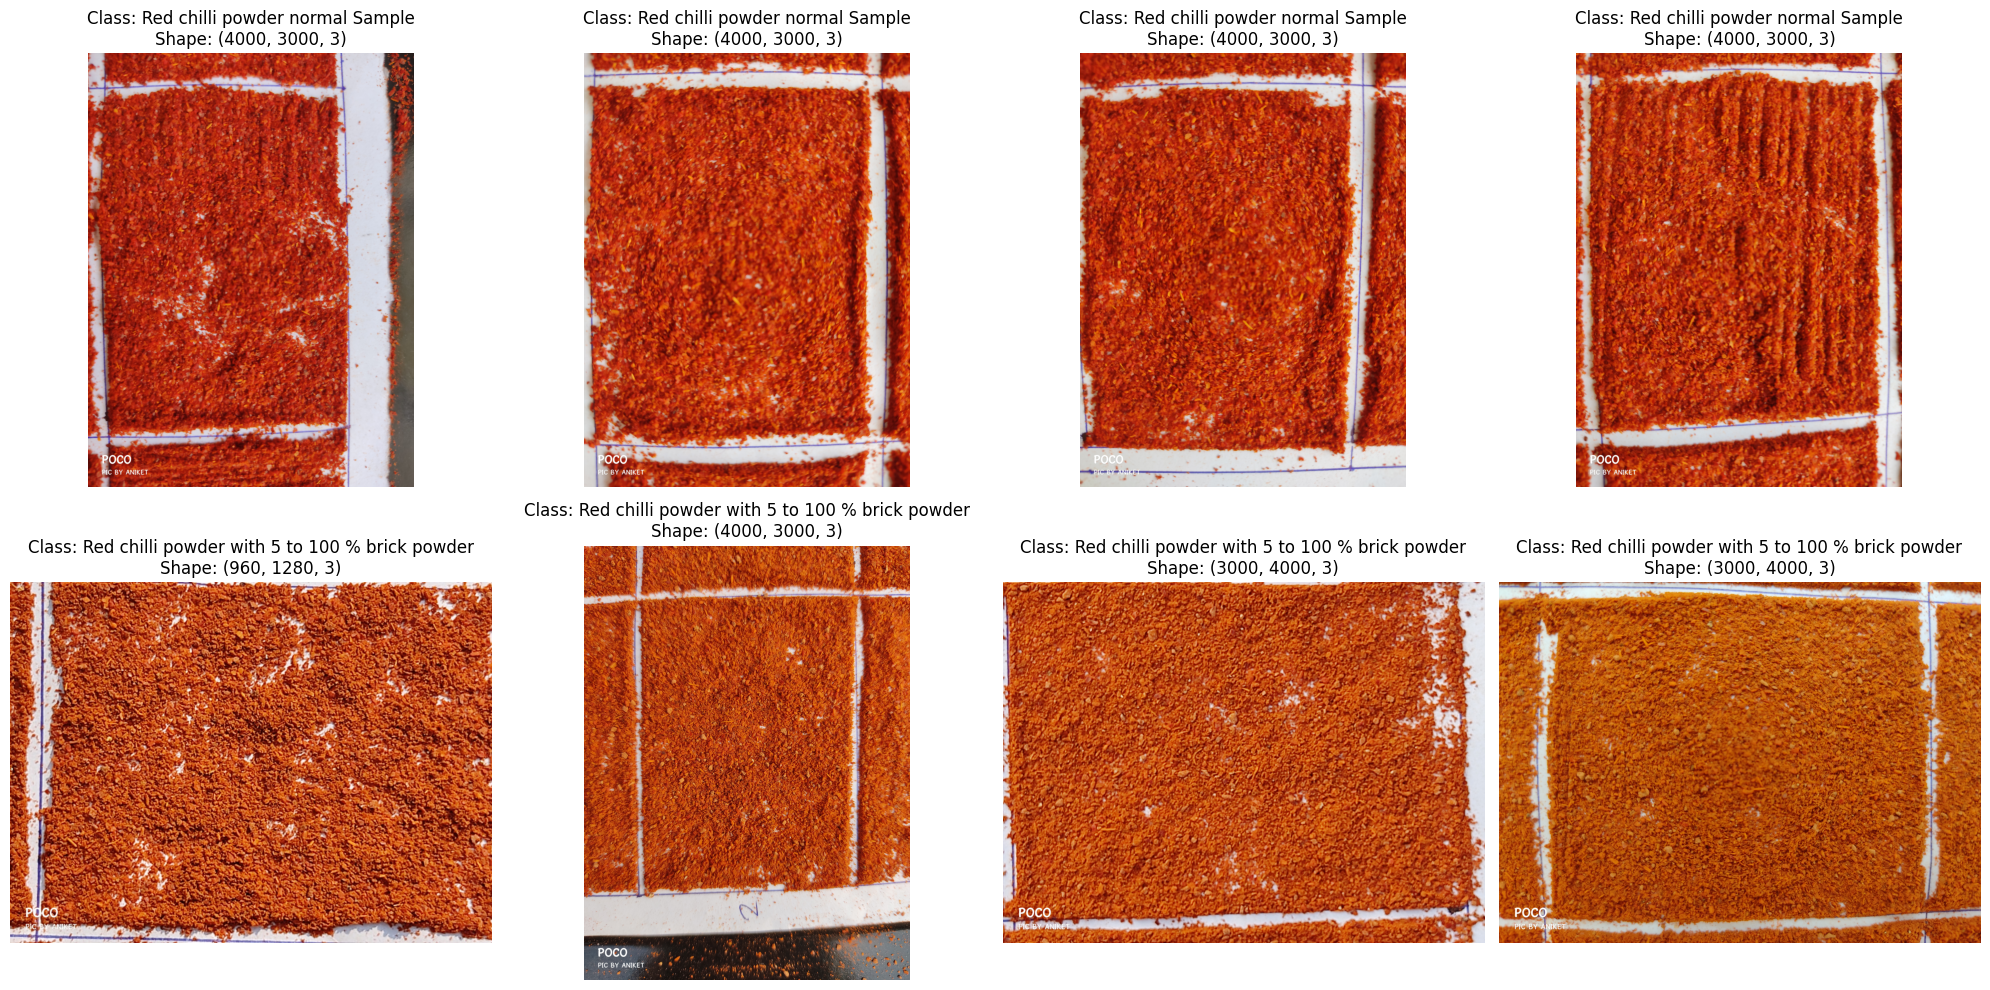

In [12]:

fig, ax = plt.subplots(nrows = len(CLASSES), ncols = 4, figsize = (20,10))
p = 0

total_images = [total_images_classe_normal,total_images_classe_anomaly]


for j in range(len(CLASSES)):
    
    total_images_classe= total_images[j]
    images_selected = random.choices(total_images_classe, k = 4)
    
    for i,img_select in enumerate(images_selected):
        img_bgr = cv2.imread(str(img_select))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(img_rgb)
        ax[p,i].set_title(f'Class: {CLASSES[j]}\nShape: {img_rgb.shape}')
        ax[p,i].axis('off')
        
    p += 1
    
fig.tight_layout()
fig.show()

In [13]:
# Normalize and reshape data
normalized_normal_images = normal_images.astype('float32') / 255
normalized_anomaly_images = anomaly_images.astype('float32') / 255
normalized_normal_images = np.reshape(normalized_normal_images, (len(normalized_normal_images), IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
normalized_anomaly_images = np.reshape(normalized_anomaly_images, (len(normalized_anomaly_images), IMAGE_SIZE[0], IMAGE_SIZE[1], 3))


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from pathlib import Path
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split


2024-05-28 09:45:16.093055: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 09:45:16.093190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 09:45:16.277931: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [15]:
# Encoder
input_img = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

In [16]:
# import keras
# from keras.layers import Input, Flatten, Dense, Reshape
# from keras.models import Model

# # Define the encoder
# encoder_input = Input(shape=(64, 64, 3), name='img')
# x = Flatten()(encoder_input)
# encoded = Dense(512, activation='relu')(x)
# encoded = Dense(64, activation='relu')(encoded)
# encoder = Model(encoder_input, encoded, name='encoder')

# # Define the decoder
# decoder_input = Input(shape=(64,), name='encoded')  # Update shape to match encoder output
# x = Dense(512, activation='relu')(decoder_input)
# x = Dense(64*64*3, activation='relu')(x)
# decoded = Reshape((64, 64, 3))(x)
# decoder = Model(decoder_input, decoded, name='decoder')

# # Define the autoencoder
# autoencoder_input = Input(shape=(64, 64, 3), name='img')
# encoded = encoder(autoencoder_input)
# decoded = decoder(encoded)
# autoencoder = Model(autoencoder_input, decoded, name='autoencoder')

# # Compile the autoencoder
# autoencoder.compile(optimizer='adam', loss='mse')

# # Print summary of the autoencoder
# autoencoder.summary()
# # normalized_normal_images.shape
# # Train the autoencoder
# history = autoencoder.fit(
#     normalized_normal_images,
#     normalized_normal_images,
#     epochs=20,
#     batch_size=32,
#     validation_split=0.1
# )

In [17]:
#Decoder 
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [18]:
from tqdm.keras import TqdmCallback
IMAGE_SIZE = (64, 64)  # Resize images to this size
BATCH_SIZE = 2048
EPOCHS = 1500
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder only on normal data
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# !rm -rf /kaggle/working/Autoencoder.pickle
import traceback
def train(autoencoder,num_runs,weights=None):
    best_loss = float('inf')  # Initialize with a very large value
    best_model_weights = weights
  # Number of training runs ###change to retrain
    for run in range(num_runs):
        # Reinitialize the autoencoder model before each training run
    #     autoencoder = build_autoencoder()  # Replace with how you create your autoencoder model

        # Train the autoencoder
        history = autoencoder.fit(
            normalized_normal_images,
            normalized_normal_images,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            shuffle=True,
            verbose=0,
            callbacks=[TqdmCallback(verbose=0)]
        )

        # Get the loss from the last epoch of this run
        final_loss = history.history['loss'][-1]

        # Check if this run achieved a better loss
        if final_loss < best_loss:
            best_loss = final_loss
            # Save the weights of the model achieving the best loss
            best_model_weights = autoencoder.get_weights()
    return best_model_weights

import pickle
try:
    with open('/kaggle/input/autoencoder-95-accuracy/keras/95percentaccuracy/1/Autoencoder.pickle', 'rb') as  f:
        weights=pickle.load(f)
        best_model_weights=train(autoencoder,0,weights) #Pretrained model weights
        autoencoder.set_weights(best_model_weights)
        
        
        
except Exception as e:
    print(traceback.format_exc())
    best_model_weights=train(autoencoder,7)
    # After all runs, load the best model weights to the autoencoder model
    autoencoder.set_weights(best_model_weights)
    
#     with open('/kaggle/working/Autoencoder.pickle', 'wb') as f:
#         pickle.dump(autoencoder.get_weights(),f)

In [20]:
with open('/kaggle/working/Autoencoder.pickle', 'wb') as f:
        pickle.dump(autoencoder.get_weights(),f)

 1/14 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step

I0000 00:00:1716889530.049688      84 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step


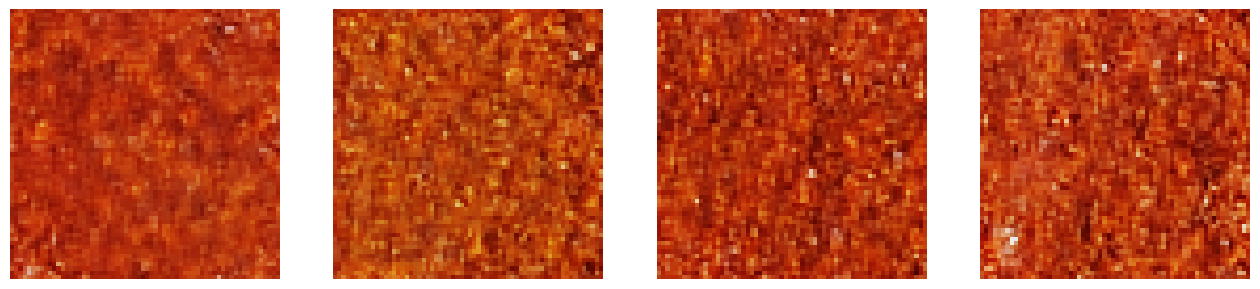

------------------------------------------------------------------------------------------------------------------------
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


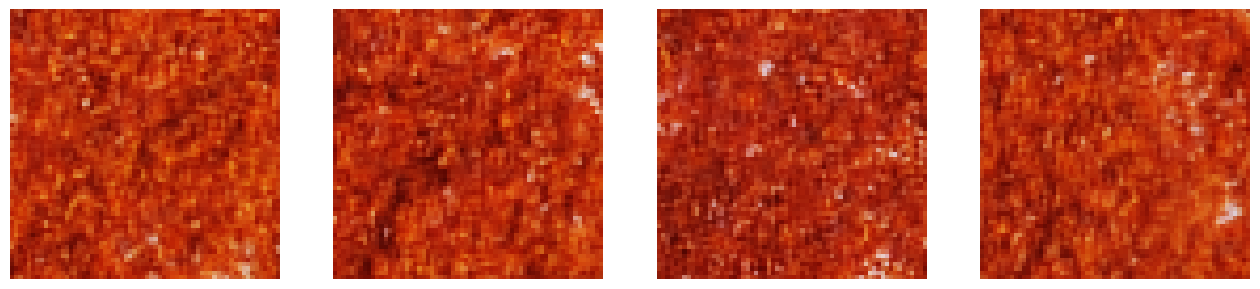

In [21]:
# Use the autoencoder to predict/reconstruct the anomaly images
decoded_anomaly_images = autoencoder.predict(normalized_anomaly_images)
display_images(decoded_anomaly_images[:4])
print("-"*120)
decoded_normal_images = autoencoder.predict(normalized_normal_images)
display_images(decoded_normal_images[:4])



In [22]:
import numpy as np
from sklearn.metrics import f1_score

# Compute MSE for normal and anomaly images
mse_normal = np.mean(np.power(normalized_normal_images - decoded_normal_images, 2), axis=(1, 2, 3))
mse_anomaly = np.mean(np.power(normalized_anomaly_images - decoded_anomaly_images, 2), axis=(1, 2, 3))

# Set a threshold for anomaly detection
threshold = np.percentile(mse_normal, 95)

# Detect anomalies
anomalies_detected = mse_anomaly > threshold
normal_detected = mse_normal > threshold

# Calculate the number of anomalies detected
num_anomalies_detected = np.sum(anomalies_detected)
num_anomalies_total = normalized_anomaly_images.shape[0]

print(f"Number of anomalies detected in anomaly dataset: {num_anomalies_detected}")
print(f"Accuracy: {num_anomalies_detected * 100 / num_anomalies_total:.2f}%")

# Calculate F1 score
# True positives (TP): anomalies correctly detected
TP = num_anomalies_detected
# False negatives (FN): anomalies not detected
FN = num_anomalies_total - num_anomalies_detected
# False positives (FP): normal images incorrectly detected as anomalies
FP = np.sum(normal_detected)
# True negatives (TN): normal images correctly identified as normal
TN = normalized_normal_images.shape[0] - FP

# Precision and recall
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

# F1 score
f1 = f1_score(np.ones(num_anomalies_total), anomalies_detected.astype(int))

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Number of anomalies detected in anomaly dataset: 422
Accuracy: 95.69%
Precision: 1.00
Recall: 0.96
F1 Score: 0.98


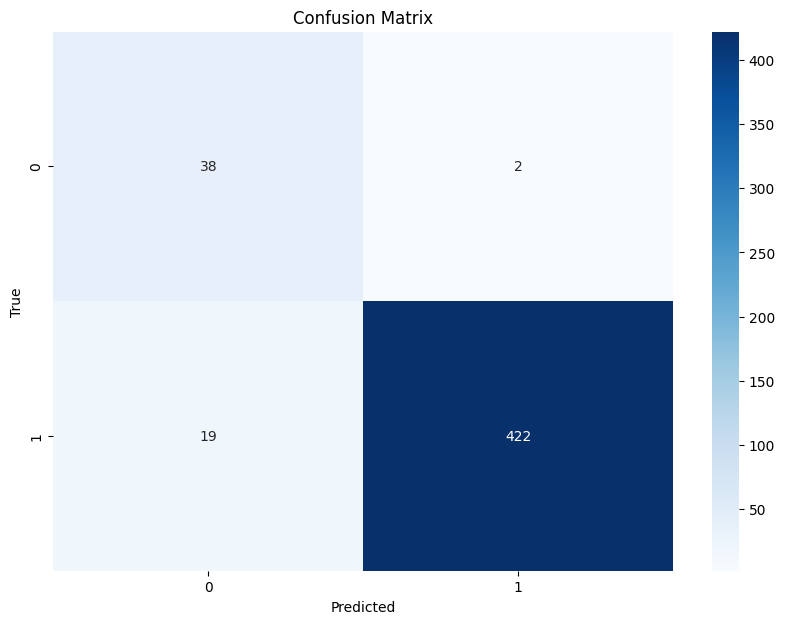

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm= np.array([[TN,FP],[FN,TP]])
#Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

#Add labels and titles
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()